In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

2022-02-22 22:54:09.788915: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-22 22:54:09.789117: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Data (from the previous chapter)
games_season = pd.read_csv('games_season.csv')
games_tourney = pd.read_csv('games_tourney.csv')

# Count the number of unique teams
team_ids = np.unique(games_season['team_1'])
n_teams = team_ids.shape[0]

In [3]:
# Team Strength Model (from the previous chapter)
from tensorflow.keras.layers import Input, Embedding, Flatten
from tensorflow.keras.models import Model

# Create an input layer for the team ID
teamid_in = Input(shape=(1,))

# Create an embedding layer
team_lookup = Embedding(input_dim=n_teams, output_dim=1, input_length=1, name='Team-Strength')

# Lookup the input in the team strength embedding layer
strength_lookup = team_lookup(teamid_in)

# Flatten the output
strength_lookup_flat = Flatten()(strength_lookup)

# Combine the operations into a single, re-usable model
team_strength_model = Model(teamid_in, strength_lookup_flat, name='Team-Strength-Model')

2022-02-22 22:54:21.835658: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-22 22:54:21.835800: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-22 22:54:21.835924: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-FC4EGDV): /proc/driver/nvidia/version does not exist
2022-02-22 22:54:21.836637: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Create a model with three inputs
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate

# Create an input for each team
team_in_1 = Input(shape=(1,), name='Team-1-In')
team_in_2 = Input(shape=(1,), name='Team-2-In')

# Create an input for home vs away
home_in = Input(shape=(1,), name='Home-In')

# lookup the team inputs in the team strength model
team_1_strength = team_strength_model(team_in_1)
team_2_strength = team_strength_model(team_in_2)

# Combine the team strengths with the home input using a Concatenate layer,
# then add a Dense layer
out = Concatenate()([team_1_strength, team_2_strength, home_in])
out = Dense(1)(out)

# Make a Model
model = Model([team_in_1, team_in_2, home_in], out)
model.compile(optimizer='adam', loss='mean_absolute_error')

In [5]:
# Fit the model to the games_season dataset
model.fit(
  x=[games_season['team_1'], games_season['team_2'], games_season['home']],
  y=games_season['score_diff'],
  epochs=1,
  verbose=1,
  validation_split=0.10,
  batch_size=2048
)

model.evaluate(
  x=[games_tourney['team_1'], games_tourney['team_2'], games_tourney['home']],
  y=games_tourney['score_diff']
)

2022-02-22 22:54:22.271603: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


133/133 [==============================] - 0s 3ms/step - loss: 11.6855


11.685470581054688

In [6]:
# Model summaries
model.summary()

# Total number of parameters is 10,892
# Number of trainable parameters is 10,892
# Layer "Team-Strength-Model (Functional)" has the most trainable parameters

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Team-1-In (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
Team-2-In (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
Team-Strength-Model (Functional (None, 1)            10888       Team-1-In[0][0]                  
                                                                 Team-2-In[0][0]                  
__________________________________________________________________________________________________
Home-In (InputLayer)            [(None, 1)]          0                                        

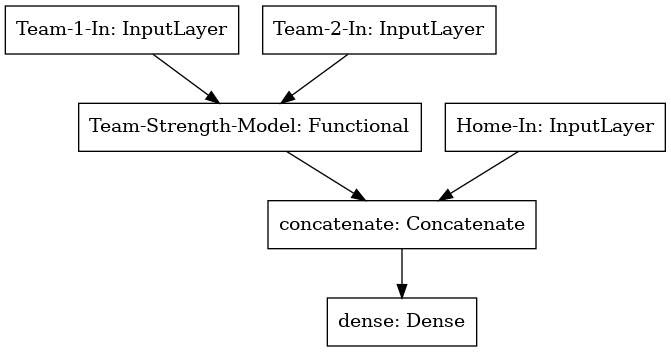

In [7]:
from tensorflow.keras.utils import plot_model

plot_model(model)

# This model has three inputs
# This model has a single output
# Layer "Team-Strength-Model (Functional)" is shared

# Model Stacking

**model stacking**: using predictions from a model as input to another model.

This approach requires us to split the training data among the different models. Thus model stacking grows the amount of data needed to train the whole sistem.

Model stacking is an advanced concept. It is a sophisticated technique.

All above indicates that model stacking is a risky and costly technique.
However, it can achieve great results.

In [8]:
games_season.head()

,season,team_1,team_2,home,score_diff,score_1,score_2,won
0,1985,3745,6664,0,17,81,64,1
1,1985,126,7493,1,7,77,70,1
2,1985,288,3593,1,7,63,56,1
3,1985,1846,9881,1,16,70,54,1
4,1985,2675,10298,1,12,86,74,1


In [9]:
games_tourney.head()

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won
0,1985,288,73,0,-3,-9,41,50,0
1,1985,5929,73,0,4,6,61,55,1
2,1985,9884,73,0,5,-4,59,63,0
3,1985,73,288,0,3,9,50,41,1
4,1985,3920,410,0,1,-9,54,63,0


In [10]:
# Add the model predictions to the tournament data
games_tourney['pred'] = model.predict([games_tourney.team_1, games_tourney.team_2, games_tourney.home])

# Save the extended dataset as csv
games_tourney.to_csv('games_tourney_extended.csv')

In [11]:
from sklearn.model_selection import train_test_split

games_tourney_train, games_tourney_test = train_test_split(games_tourney, test_size=1066)

In [12]:
# Create an input layer with three columns
input_tensor = Input((3,))

# Pass it to a Dense layer with one unit
output_tensor = Dense(1)(input_tensor)

# Create a model
model = Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

# Fit the model
model.fit(
  games_tourney_train[['home', 'seed_diff', 'pred']],
  games_tourney_train['score_diff'],
  verbose=1
)

99/99 [==============================] - 1s 6ms/step - loss: 10.0263


In [13]:
# Evaluate the model on the games_tourney_test dataset
# This metric can be as high as 13.0 in random initialization and training
model.evaluate(
  games_tourney_test[['home', 'seed_diff', 'pred']],
  games_tourney_test['score_diff'],
  verbose=0
)

9.80820083618164